## Cargar librerías

In [2]:
import requests
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
#from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

## Descargar los datos

In [2]:
def fetch_bitstamp_data(symbol, start, end, timeframe, limit=1000):
    url = f"https://www.bitstamp.net/api/v2/ohlc/{symbol}/"
    data_frames = []
    
    while start < end:
        # Ajustar end para la solicitud actual para no exceder el límite de 1000 registros
        current_end = min(start + (timeframe * limit), end)
        # Debug
        #print(f"{pd.to_datetime(start, unit='s')} - {pd.to_datetime(current_end, unit='s')}")
        params = {
            'start': int(start),
            'end': int(current_end),
            'step': timeframe,
            'limit': limit,
            'exclude_current_candle': False
        }
        try:
            response = requests.get(url, params=params)
            if response.status_code == 200:
                data = response.json()
                df = pd.DataFrame(data['data']['ohlc'])
                if not df.empty:
                    data_frames.append(df)
            else:
                raise Exception(f"Failed to fetch data: {response.status_code}, {response.text}")
        except Exception as e:
            print(e)
            break

        start = current_end
    # Combinar todos los DataFrames
    if data_frames:
        df = pd.concat(data_frames, ignore_index=True)
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        df = df.set_index('timestamp')
        df = df.sort_index()
        df.index.name = 'date'
        df = df.astype({
            'open': float,
            'high': float,
            'low': float,
            'close': float,
            'volume': float
        })
        return df
    else:
        return pd.DataFrame()

# Uso de ejemplo
start_date = pd.Timestamp('2011-01-01').timestamp()
end_date = pd.Timestamp.now(tz='UTC').timestamp()

df = fetch_bitstamp_data('btcusd', start=start_date, end=end_date, timeframe=3600)

## Análisis exploratorio de datos

In [3]:
df.shape

(113493, 5)

In [4]:
df.describe()

,open,high,low,close,volume
count,113493.000000,113493.000000,113493.000000,113493.000000,113493.000000
mean,13156.451867,13218.104848,13090.364233,13157.032317,322.619625
std,18185.199551,18266.871777,18097.922661,18185.875070,581.820227
min,2.220000,2.230000,2.220000,2.230000,0.000000
25%,354.880000,356.750000,352.500000,354.730000,50.347216
50%,4410.000000,4447.330000,4379.780000,4412.980000,148.026673
75%,20336.000000,20431.000000,20237.000000,20336.390000,363.039168
max,73608.000000,73794.000000,73247.000000,73608.000000,20551.251040


## Ingeniería de características

In [5]:
# Crear indicadores técnicos
df['short_mavg'] = talib.SMA(real=df['close'], timeperiod=10)
df['long_mavg'] = talib.SMA(real=df['close'], timeperiod=60)
df['ema10'] = talib.EMA(real=df['close'], timeperiod=10)
df['ema30'] = talib.EMA(real=df['close'], timeperiod=30)
df['ema200'] = talib.EMA(real=df['close'], timeperiod=200)
df['roc10'] = talib.ROC(real=df['close'], timeperiod=10)
df['roc30'] = talib.ROC(real=df['close'], timeperiod=30)
df['mom10'] = talib.MOM(real=df['close'], timeperiod=10)
df['mom30'] = talib.MOM(real=df['close'], timeperiod=30)
df['rsi10'] = talib.RSI(real=df['close'], timeperiod=10)
df['rsi30'] = talib.RSI(real=df['close'], timeperiod=30)
df['rsi200'] = talib.RSI(real=df['close'], timeperiod=200)
df['k10'], df['d10'] = talib.STOCH(high=df['high'], low=df['low'], close=df['close'], fastk_period=10, slowk_period=10, slowd_period=10)
df['k30'], df['d30'] = talib.STOCH(high=df['high'], low=df['low'], close=df['close'], fastk_period=30, slowk_period=30, slowd_period=30)
df['k200'], df['d200'] = talib.STOCH(high=df['high'], low=df['low'], close=df['close'], fastk_period=200, slowk_period=200, slowd_period=200)

In [6]:
# Comprobar valores nulos
if df.isnull().values.any():
    df = df.dropna()
print(f'Null values = {df.isnull().values.any()}')

Null values = False


In [7]:
# Generar la señal
df['signal'] = np.where(df['short_mavg'] > df['long_mavg'], 1.0, 0.0)

In [8]:
# Excluir características innecesarias para la predicción
df = df.drop(columns=['high', 'low', 'open', 'short_mavg', 'long_mavg'], axis=1)

In [9]:
df

,close,volume,ema10,ema30,ema200,roc10,roc30,mom10,mom30,rsi10,rsi30,rsi200,k10,d10,k30,d30,k200,d200,signal
date,,,,,,,,,,,,,,,,,,,
2011-09-12 09:00:00,7.4,0.000000,7.400000,7.403442,7.969308,0.000000,0.000000,0.0,0.0,1.382233,12.005946,27.891217,-1.136868e-14,3.403500e-14,0.000000,1.172247e-13,48.047684,50.538182,1.0
2011-09-12 10:00:00,7.4,0.000000,7.400000,7.403220,7.963643,0.000000,0.000000,0.0,0.0,1.382233,12.005946,27.891217,-1.136868e-14,3.403500e-14,0.000000,1.172247e-13,47.665578,50.667938,1.0
2011-09-12 11:00:00,7.4,0.000000,7.400000,7.403012,7.958035,0.000000,0.000000,0.0,0.0,1.382233,12.005946,27.891217,-1.136868e-14,3.403500e-14,0.000000,1.172247e-13,47.283473,50.793873,1.0
2011-09-12 12:00:00,7.4,0.000000,7.400000,7.402818,7.952482,0.000000,0.000000,0.0,0.0,1.382233,12.005946,27.891217,-1.136868e-14,3.403500e-14,0.000000,1.172247e-13,46.901368,50.915987,1.0
2011-09-12 13:00:00,7.4,0.000000,7.400000,7.402636,7.946985,0.000000,0.000000,0.0,0.0,1.382233,12.005946,27.891217,-1.136868e-14,3.403500e-14,0.000000,1.172247e-13,46.519263,51.034279,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-22 14:00:00,66700.0,227.194963,67324.926342,67362.580641,64814.933445,-1.809242,-0.193030,-1229.0,-129.0,34.468653,47.502455,54.131941,2.490722e+01,4.893282e+01,64.931534,6.562995e+01,90.504813,75.300705,1.0
2024-07-22 15:00:00,67071.0,92.787910,67278.757917,67343.768987,64837.381869,-0.814824,0.111947,-551.0,75.0,43.661624,50.384287,54.519125,2.569406e+01,4.373936e+01,64.765822,6.539216e+01,90.446882,75.503628,1.0
2024-07-22 16:00:00,67071.0,97.159584,67240.983750,67326.170988,64859.606925,-0.499941,0.372632,-337.0,249.0,43.661624,50.384287,54.519125,2.731947e+01,3.930196e+01,65.051823,6.521217e+01,90.383657,75.704561,1.0


## Visualización de datos

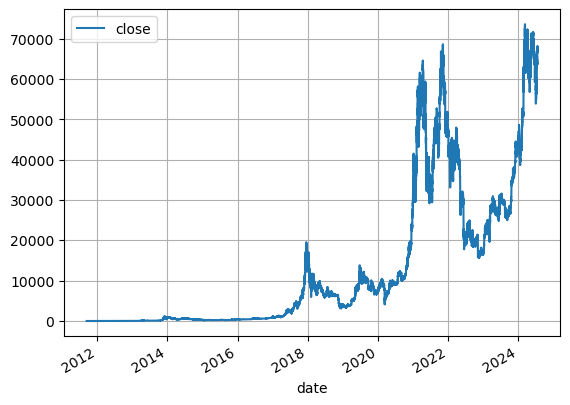

In [10]:
df[['close']].plot(grid=True)
plt.show()

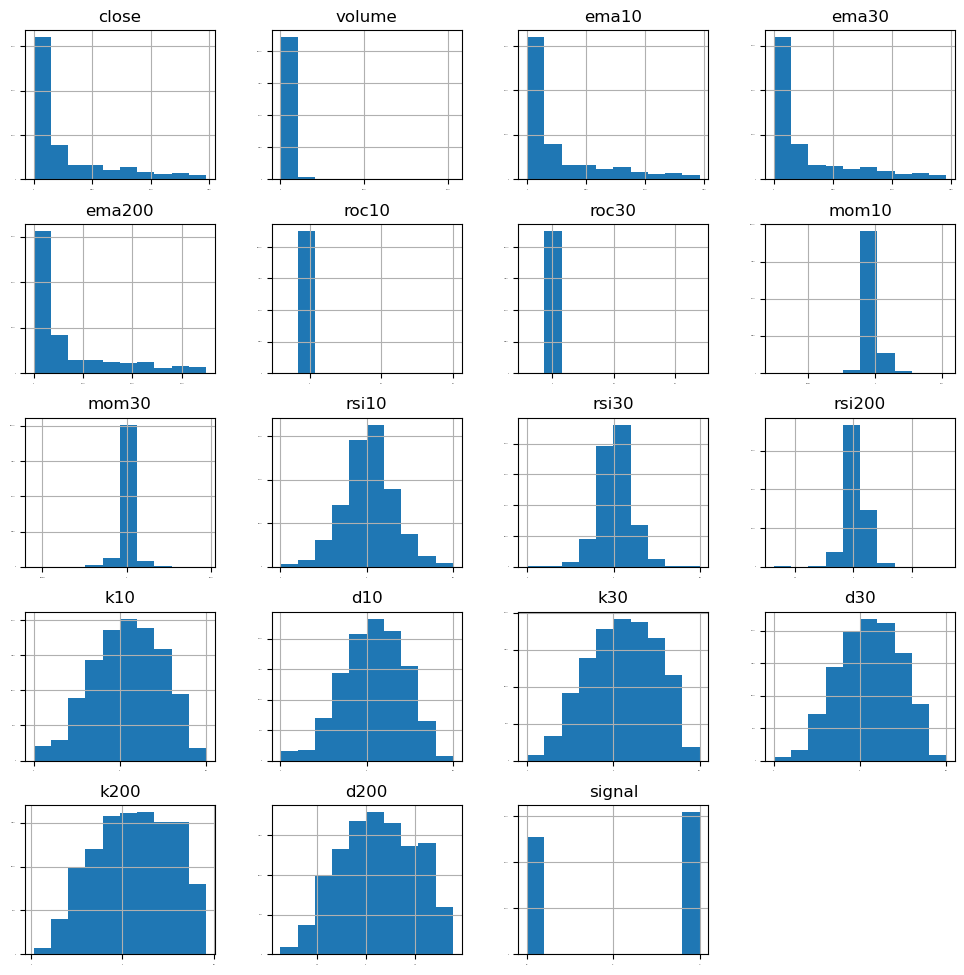

In [11]:
df.hist(sharex=False, sharey= False, xlabelsize=1, ylabelsize=1, figsize=(12, 12))
plt.show()

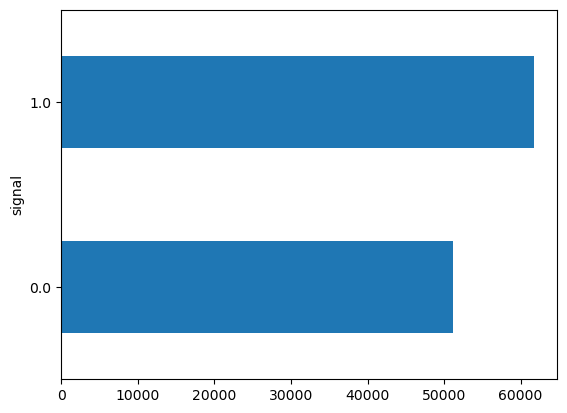

In [12]:
df.groupby(['signal']).size().plot(kind='barh')
plt.show()

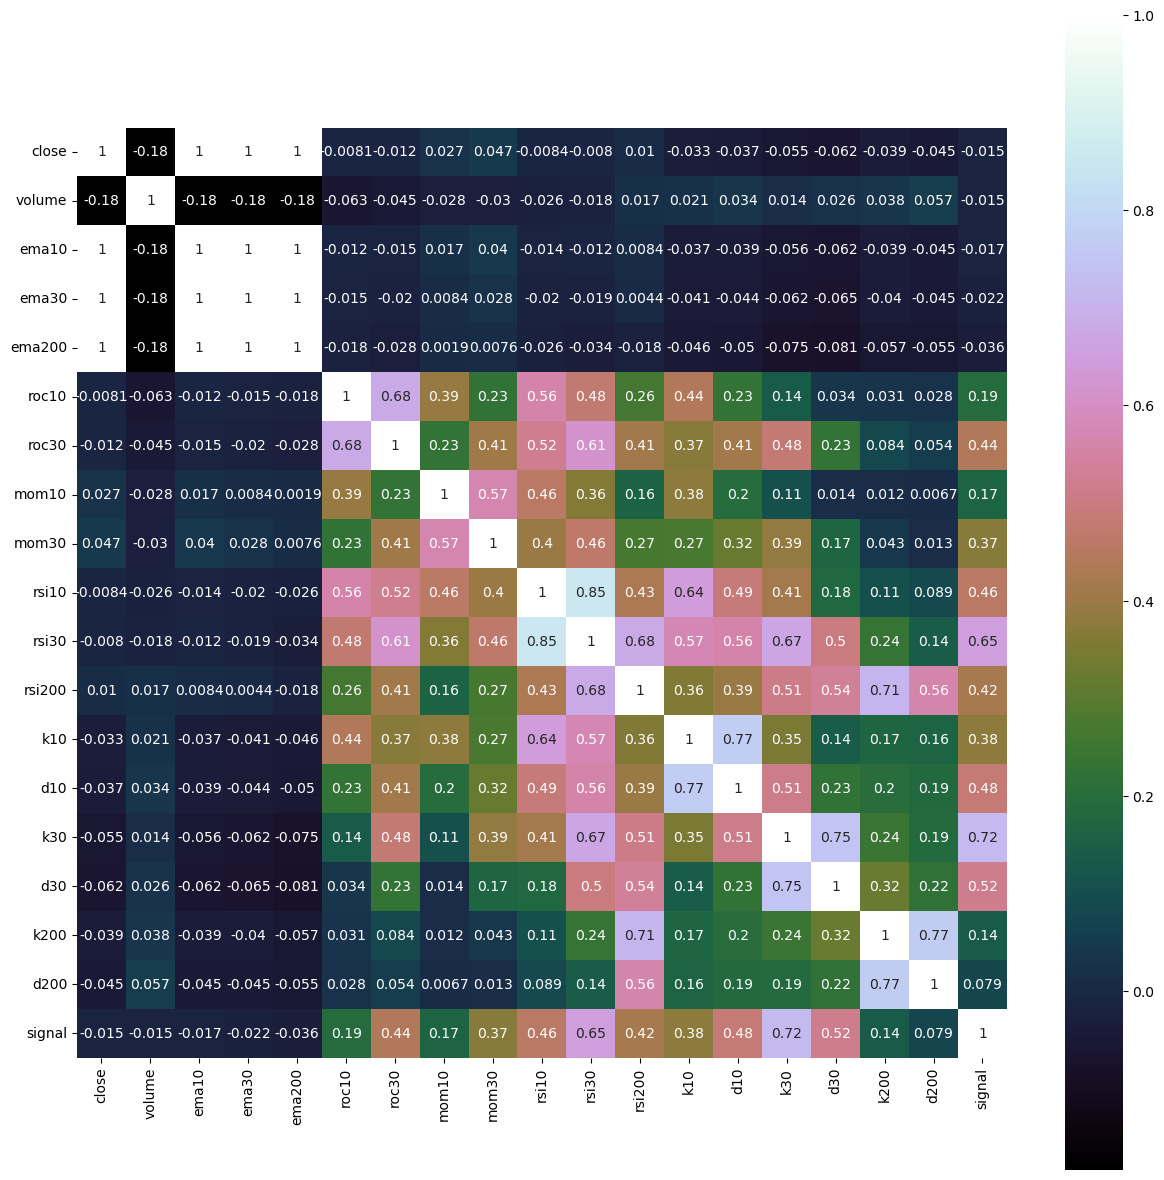

In [13]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), vmax=1, square=True, annot=True, cmap='cubehelix')
plt.show()

## Evaluar algoritmos y modelos

In [14]:
# Train and test split
Y = df['signal']
X = df.loc[:, df.columns != 'signal']
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [15]:
# Modelos
models = []
models.append(('LR', LogisticRegression(verbose=0)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier(verbose=0)))
models.append(('RF', RandomForestClassifier(verbose=0)))
#models.append(('SVM', SVC()))
models.append(('XGB', XGBClassifier()))
models.append(('LGBM', LGBMClassifier()))
models.append(('CAT', CatBoostClassifier(verbose=0)))
models.append(('SGD', SGDClassifier(verbose=0)))
models.append(('BAG', BaggingClassifier(verbose=0)))
models.append(('ET', ExtraTreesClassifier(verbose=0)))

In [16]:
# Opciones
num_folds = 10
scoring = 'accuracy'

In [17]:
results = []
names = []
best = {'model': '', 'cv_result': float('-inf')}
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    if cv_results.mean() > best['cv_result']:
        best['model'] = name
        best['cv_result'] = cv_results.mean()
    print(f'{name}: {cv_results.mean()} ({cv_results.std()})')

LR: 0.8537057979801685 (0.07389667754224996)
LDA: 0.9019780994486168 (0.023915133410701023)
KNN: 0.71222049943316 (0.06752923640528587)
CART: 0.8384143194305924 (0.1581963643935261)
NB: 0.8606112113192637 (0.03396253696727298)
AB: 0.9137478350576534 (0.02247039081641852)
GBM: 0.9185642647669935 (0.023024774399871297)
RF: 0.9186418111163015 (0.023977393230325862)
XGB: 0.92586075307579 (0.019798401367748526)
[LightGBM] [Info] Number of positive: 45027, number of negative: 36257
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 81284, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553947 -> initscore=0.216630
[LightGBM] [Info] Start training from score 0.216630
[LightGBM] [Info] Number of positive: 44673, number of negative: 36611
[LightGBM] [Info] Auto-choo

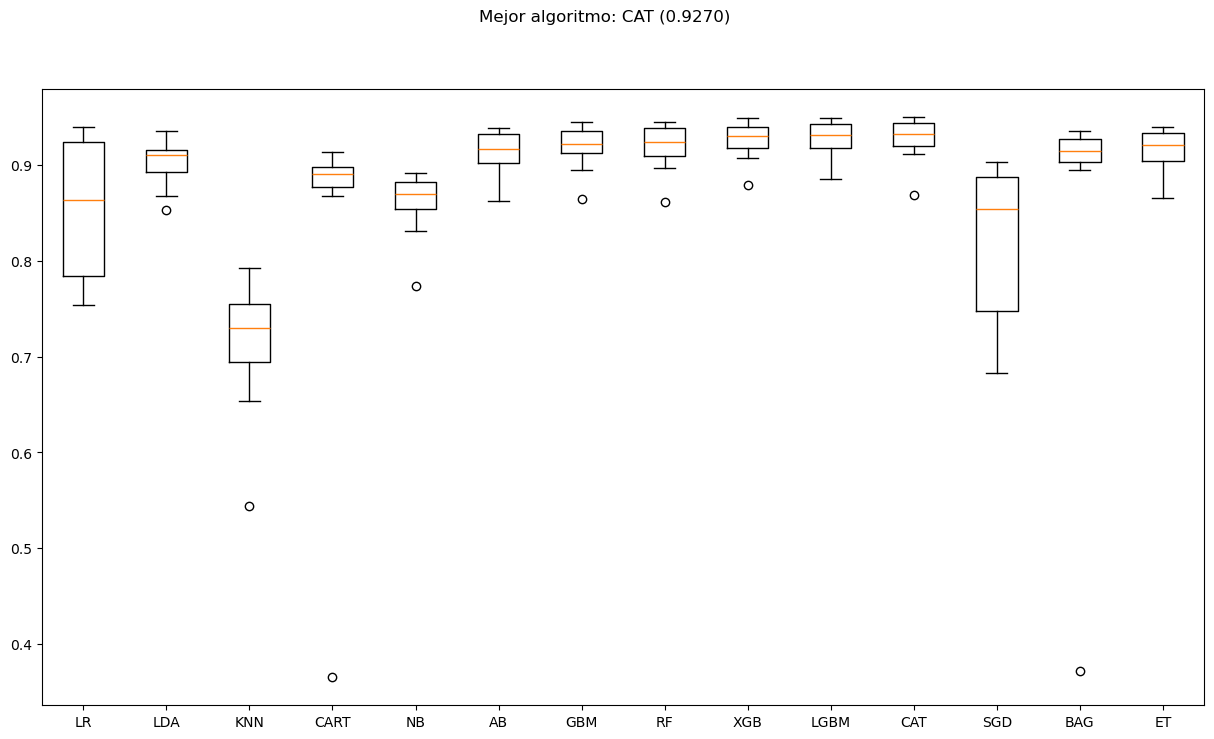

In [18]:
# comparar algoritmos
fig = plt.figure()
fig.suptitle(f"Mejor algoritmo: {best['model']} ({best['cv_result']:.4f})")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
plt.show()

## Tuning del modelo

In [19]:
# Normalización
scaler = StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)
# Parámetros a optimizar con grid
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'iterations': [100, 200],
    'l2_leaf_reg': [1, 5],
    'border_count': [32, 50],
    'bagging_temperature': [0.0, 0.5],
    'random_strength': [1, 5],
    'one_hot_max_size': [2, 10]
}
model = CatBoostClassifier(verbose=0)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid= param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_scaled, Y_train)

In [20]:
# Print results
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print(f'#{rank} {mean} ({stdev}) with: {param}')
print(f'#{grid_result.best_index_} Best: {grid_result.best_score_} using {grid_result.best_params_}')

#369 0.8994646932095618 (0.02362898279779021) with: {'bagging_temperature': 0.0, 'border_count': 32, 'depth': 4, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.01, 'one_hot_max_size': 2, 'random_strength': 1}
#365 0.9002729146501485 (0.02234720417866584) with: {'bagging_temperature': 0.0, 'border_count': 32, 'depth': 4, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.01, 'one_hot_max_size': 2, 'random_strength': 5}
#369 0.8994646932095618 (0.02362898279779021) with: {'bagging_temperature': 0.0, 'border_count': 32, 'depth': 4, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.01, 'one_hot_max_size': 10, 'random_strength': 1}
#365 0.9002729146501485 (0.02234720417866584) with: {'bagging_temperature': 0.0, 'border_count': 32, 'depth': 4, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.01, 'one_hot_max_size': 10, 'random_strength': 5}
#153 0.9196383441681389 (0.023260268896861867) with: {'bagging_temperature': 0.0, 'border_count': 32, 'depth': 4, 'iterations'

In [21]:
np.where(grid_result.cv_results_['rank_test_score'] == 1)

(array([188, 190, 380, 382], dtype=int64),)

## Resultados del modelo tuneado

In [22]:
model = CatBoostClassifier(
    depth=grid_result.best_params_['depth'],
    learning_rate=grid_result.best_params_['learning_rate'],
    iterations=grid_result.best_params_['iterations'],
    l2_leaf_reg=grid_result.best_params_['l2_leaf_reg'],
    border_count=grid_result.best_params_['border_count'],
    bagging_temperature=grid_result.best_params_['bagging_temperature'],
    random_strength=grid_result.best_params_['random_strength'],
    one_hot_max_size=grid_result.best_params_['one_hot_max_size'],
    )
model.fit(X_train, Y_train)

0:	learn: 0.5490239	total: 22.3ms	remaining: 4.44s
1:	learn: 0.4555269	total: 39.7ms	remaining: 3.93s
2:	learn: 0.3867713	total: 56.4ms	remaining: 3.7s
3:	learn: 0.3396790	total: 72.2ms	remaining: 3.54s
4:	learn: 0.3068486	total: 88.5ms	remaining: 3.45s
5:	learn: 0.2802635	total: 104ms	remaining: 3.35s
6:	learn: 0.2626010	total: 120ms	remaining: 3.3s
7:	learn: 0.2482336	total: 135ms	remaining: 3.25s
8:	learn: 0.2371866	total: 158ms	remaining: 3.34s
9:	learn: 0.2290573	total: 176ms	remaining: 3.34s
10:	learn: 0.2221501	total: 191ms	remaining: 3.29s
11:	learn: 0.2160311	total: 208ms	remaining: 3.25s
12:	learn: 0.2109166	total: 223ms	remaining: 3.21s
13:	learn: 0.2064152	total: 239ms	remaining: 3.18s
14:	learn: 0.2022862	total: 257ms	remaining: 3.17s
15:	learn: 0.1988359	total: 273ms	remaining: 3.14s
16:	learn: 0.1956177	total: 289ms	remaining: 3.12s
17:	learn: 0.1933056	total: 304ms	remaining: 3.07s
18:	learn: 0.1907970	total: 319ms	remaining: 3.04s
19:	learn: 0.1883039	total: 334ms	rema

In [23]:
# resultados en validation set
y_pred = model.predict(X_validation)
print(accuracy_score(Y_validation, y_pred))
print(confusion_matrix(Y_validation, y_pred))
print(classification_report(Y_validation, y_pred))

0.9219220549158548
[[10540   577]
 [ 1186 10277]]
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92     11117
         1.0       0.95      0.90      0.92     11463

    accuracy                           0.92     22580
   macro avg       0.92      0.92      0.92     22580
weighted avg       0.92      0.92      0.92     22580



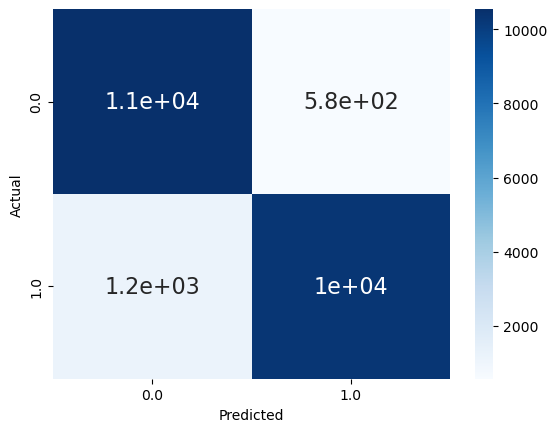

In [24]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, y_pred), columns=np.unique(Y_validation), index=np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={'size': 16})
plt.show()

In [27]:
y_score

array([[0.0165502 , 0.9834498 ],
       [0.00365603, 0.99634397],
       [0.00554901, 0.99445099],
       ...,
       [0.22303177, 0.77696823],
       [0.06456714, 0.93543286],
       [0.0351595 , 0.9648405 ]])

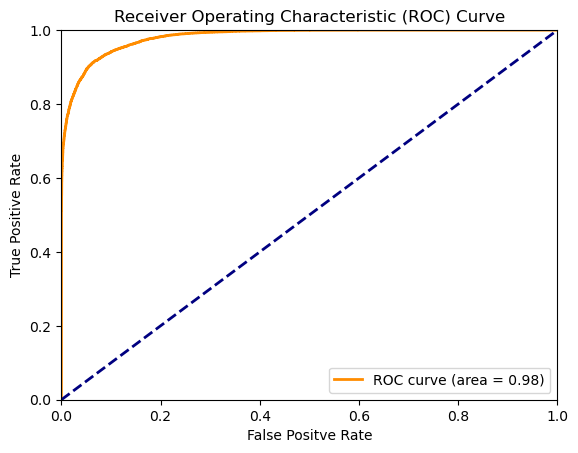

In [28]:
# ROC curve
y_score = model.predict_proba(X_validation)[:, 1]
fpr, tpr, _ = roc_curve(Y_validation, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positve Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Intuición de variables / Importancia de características

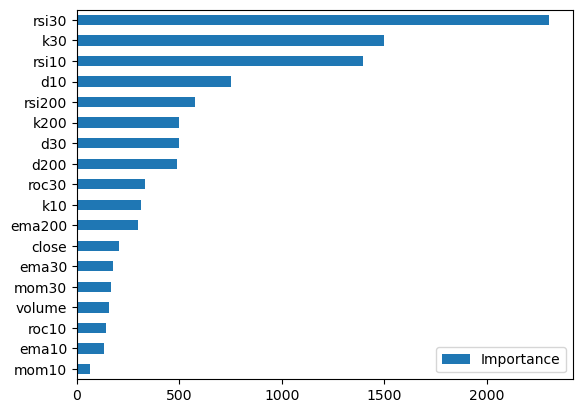

In [29]:
features_importance = pd.DataFrame({'Importance': model.feature_importances_*100}, index=X.columns)
features_importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh')
plt.show()

## Backtesting results

In [30]:
# Crear una columna con los retornos de la estrategia multiplicando
# la señal al cierre de la vela anterior por el retorno de la vela siguiente
backtestdata = pd.DataFrame(index=X_validation.index)
backtestdata['signal_pred'] = y_pred
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata = backtestdata.dropna()

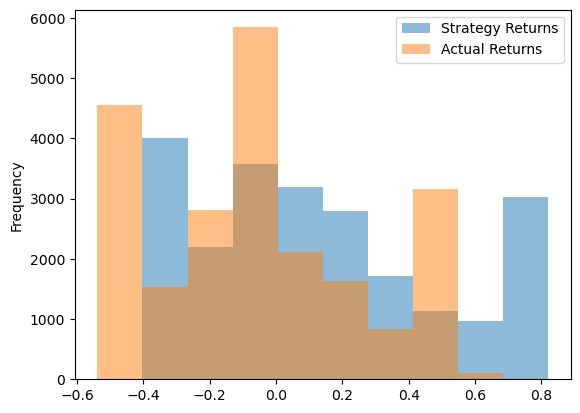

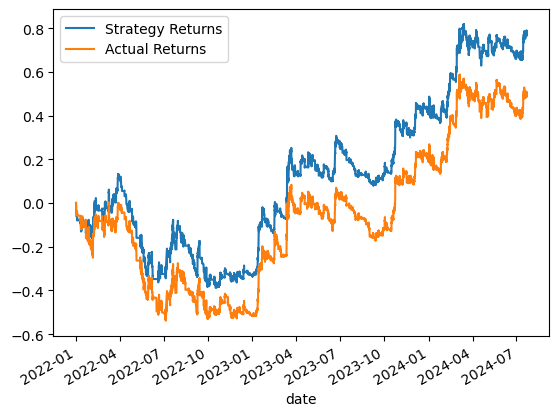

In [31]:
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot(kind='hist', alpha=0.5)
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot(kind='line')
plt.show()